# PSR J1023+0038 Light Curve
### Adam Mendoza

We will use the dataset obtained from the XMM-Newton Optical Monitor (OM) starting from `2017 June 9` at `22:32:27` until `2017 June 10 5:02:13`. The data measures optical brightness in the B filter band, which captures light around a central wavelength of $450\ \text{nm}$ in the blue region of the visible spectrum. The unit of flux that is used is $\text{mJy}$. The paper can be accessed [here](https://www.aanda.org/articles/aa/pdf/2019/11/aa36008-19.pdf).

In [53]:
# Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

We will define a function that calculates the MSD of a given arbitrary dataset. By definition,

$$\text{MSD}(\Delta)=\frac{1}{N-\Delta}\sum_{k=0}^{N-\Delta-1}\left({X(t_k+\Delta)-X(t_k)}\right)^2.$$

We will implement this function:

In [54]:
def msd_array(data):

    data = np.array(data)
    N = len(data)
    msd_vals = []

    for delta in range(1, N):
        msd_vals.append(np.mean([(data[k + delta] - data[k]) ** 2 for k in range(N - delta)]))

    return msd_vals[:int(len(msd_vals)/2)] #we will only take half of it since larger lag time = smaller samples = noisy


## Detrending Functions

There are different ways on detrending datasets. The idea is we want to extract the trends of an arbitrary dataset so that the noise remains. First, we will define a function that takes the moving average of a dataset given a window.

In [55]:
def mov_ave(data, window):
    data = np.array(data)
    ave_trend = []
    window = int(window)

    for i in range(len(data)-2*window): 
        ave_trend.append(np.mean(data[i:i+2*window+1])) #we want to take the average of the slice centered at i + window.
    
    return ave_trend 

# note that the moving average technique excludes the edges of the data, leaving us with corresponding data[window:-window].

def mov_ave_detrend(data, window):

    data = np.array(data)
    window = int(window)
    trend = mov_ave(data, window) #we get the trend from the moving average method

    detrend = data[window:-window] - trend #exclude the values not considered by mov_ave. subtract the mov_ave trend from the remaining data

    return detrend

We can also detrend using FFT. The idea here is that we want to exclude high frequency terms, making it 0, leaving us with low frequency values. Transforming it back to the original space will leave us with the detrended data.

In [56]:
def fft_detrend(data, threshold):
    
    # threshold = percentage relative to the maximum value of the fft of the data 

    data = np.array(data)
    fft_data = np.fft.rfft(data)
    adapted_threshold = threshold*np.max(fft_data)
    lowpass_fft = []

    for i in range(len(fft_data)):
        if np.abs(fft_data[i]) < adapted_threshold: #frequency values above adapted_threshold are excluded
            lowpass_fft.append(fft_data[i])
        else:
            lowpass_fft.append(0)

    lowpass_data = np.fft.irfft(lowpass_fft)
    return lowpass_data

## Application: Random Walk

We will simulate a random walk.

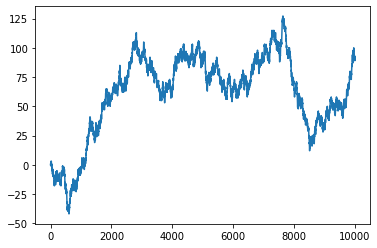

In [57]:
np.random.seed(30)

n_points = 10**4 # initiate number of steps
rand_walk = [0] # initial position

for i in range(n_points):
    val = np.random.rand()
    if val < 0.5: #we want 0.5 since we want left and right steps to be equally likely
        rand_walk.append(-1 + rand_walk[i])
    else:
        rand_walk.append(1 + rand_walk[i])

plt.plot(rand_walk)
plt.show()

We will detrend this. It is more appropriate to use the method of moving averages with a window of 100. The trend looks like:

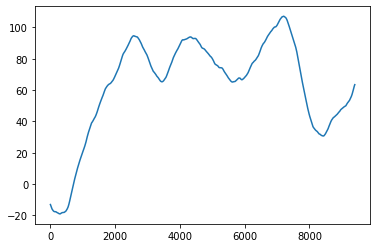

In [58]:
rw_window = 300

rw_trend = mov_ave(rand_walk, rw_window)
plt.plot(rw_trend)
plt.show()

Detrending, the plot now looks like this:

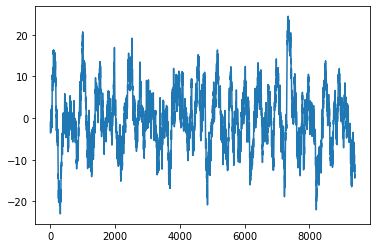

In [59]:
rw_detrend = mov_ave_detrend(rand_walk, rw_window)
plt.plot(rw_detrend)
plt.show()

Now that we have detrended it, we will look at the distribution of the noise through the histogram. We will use the Terrell-Scott rule for the number of bins, saying that the optimal number must be $(2n)^{1/3}$

In [60]:
def tscott_bins(data):
    return int((2*len(rw_detrend))**(1/3))

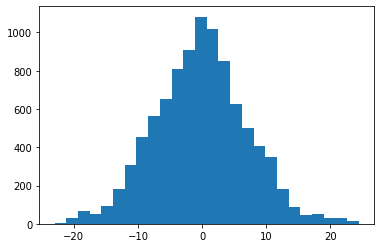

In [61]:
plt.hist(rw_detrend, bins = tscott_bins(rw_detrend))
plt.show()

We can see that it is normally distributed. Next, we can check for the MSD plot.

In [62]:
def msd_plot(data, x_scale = 'linear', y_scale = 'linear', title = 'MSD Plot', a = '1'):

    plt.title(str(title))
    plt.xlabel('Lag Time ($\Delta$)')
    plt.ylabel('MSD')
    plt.xscale(str(x_scale))
    plt.yscale(str(y_scale))
    plt.plot(data, alpha = float(a))

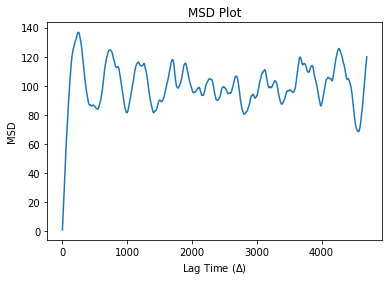

In [63]:
msd_rw = msd_array(rw_detrend)
msd_plot(msd_rw)

## PSR J1023+0038

We will now apply the functions and techniques in our pulsar data. 

In [64]:
#Initiate the data

light_curve = pd.read_csv("..//datasets//light_curves//JAA631A104om.csv")
light_curve.head()

,Time,Flux,e_Flux
0,-5253.208496,0.549461,0.095646
1,-5243.208496,0.630092,0.099528
2,-5233.208496,0.445528,0.091511
3,-5223.208496,0.629439,0.099528
4,-5213.208496,0.698945,0.103198


The plot looks like this:

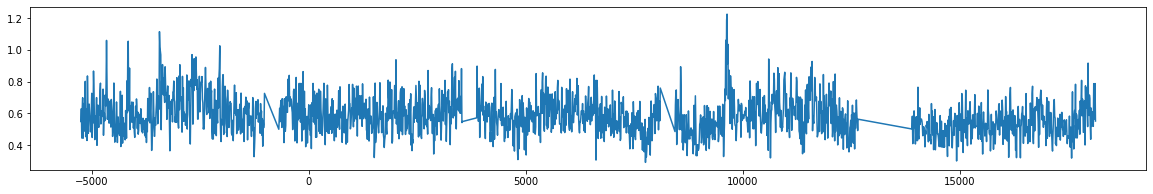

In [65]:
plt.figure(figsize=(20,3))
plt.plot(light_curve.Time, light_curve.Flux)
plt.show()

There are gaps in the data that are probably null. For now, we will ignore these gaps (not really sure if this is a good idea) and attach the pieces together. We will now plot the flux curve and its detrended counterpart.

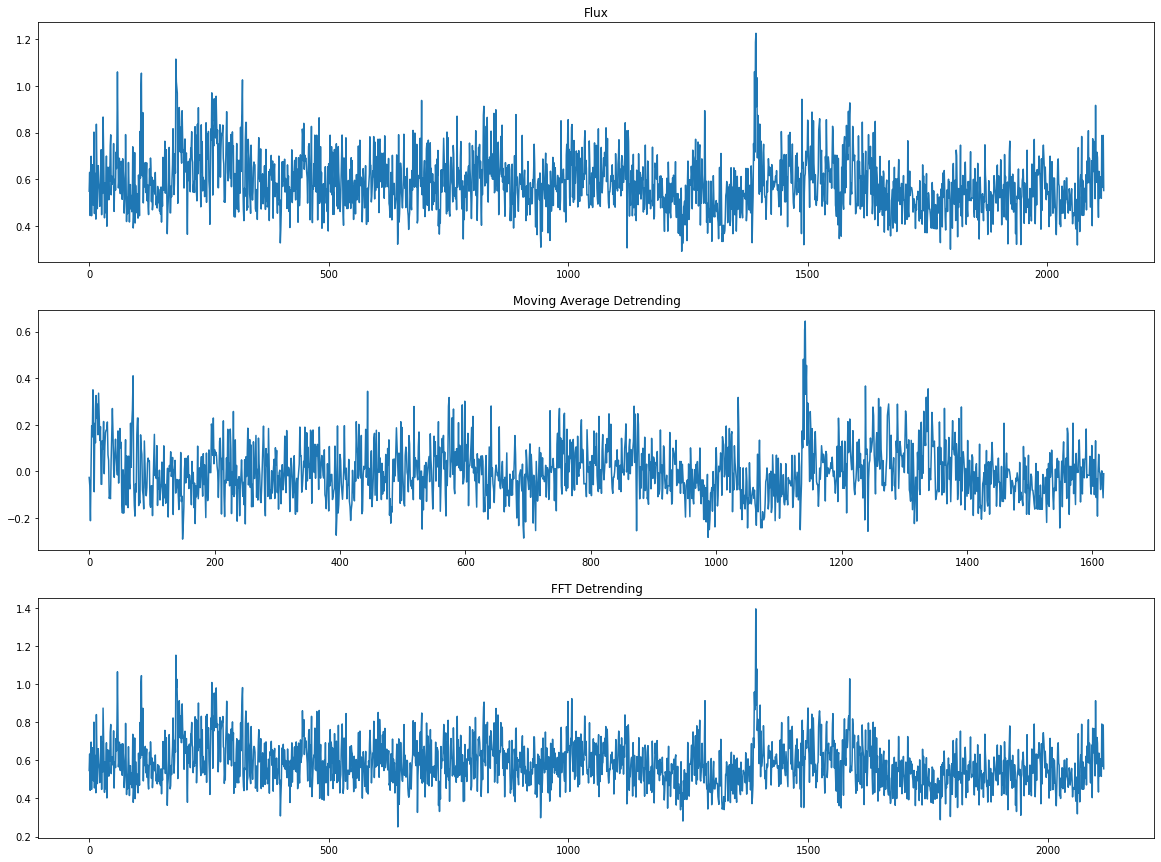

In [66]:
flux = light_curve.Flux
movave_flux = mov_ave_detrend(flux, 250)
fft_flux = fft_detrend(flux, 250)

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.title('Flux')
plt.plot(flux)

plt.subplot(3,1,2)
plt.title('Moving Average Detrending')
plt.plot(movave_flux)

plt.subplot(3,1,3)
plt.title('FFT Detrending')
plt.plot(fft_flux)

plt.show()

We can check the distribution of our detrended data.

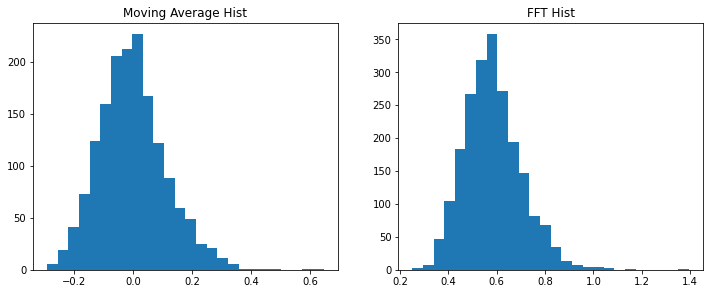

In [67]:
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
plt.hist(movave_flux, bins = tscott_bins(movave_flux))
plt.title('Moving Average Hist')

plt.subplot(2,2,2)
plt.hist(fft_flux, bins = tscott_bins(fft_flux))
plt.title('FFT Hist')

plt.show()

Both detrending methods yield a Gaussian distribution. We will calculate the MSD resulting from these detrending.

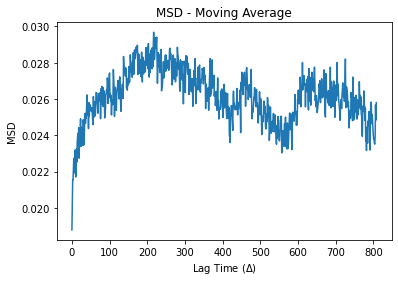

In [68]:
movave_msd = msd_array(movave_flux)
msd_plot(movave_msd, title = 'MSD - Moving Average')

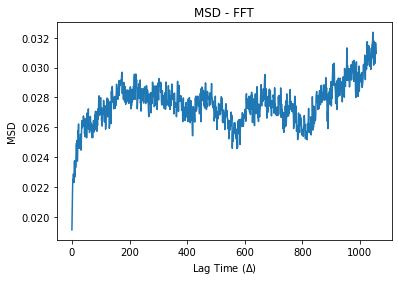

In [69]:
fft_msd = msd_array(fft_flux)
msd_plot(fft_msd, title = 'MSD - FFT')

We will now write the theoretical MSD. Take

$$\text{MSD}_{\text{theo}}(t) = \Gamma(\mu)t^{\mu-1}\beta^{-\mu}e^{-\beta/t}$$

We will find the optimal values of $\mu$ and $\beta$ that gives the lowest error.

In [70]:
from sklearn.metrics import mean_absolute_error #for error value

def msd_theo(t, mu, beta):
    return sp.special.gamma(mu)*t**(mu-1)*beta**(-mu)*np.exp(-beta/t)

msd_lag = np.array([*range(50,int(len(fft_msd)+49))]) #this shift is not yet justified

error_list = {}
for mu in np.linspace(10**-10, 1,200):
    for beta in np.linspace(10**-10, 20,200):
        msd_theo_array = msd_theo(msd_lag, mu, beta) + fft_msd[0] - msd_theo(msd_lag, mu, beta)[0]
        error_list[(mu,beta)] = mean_absolute_error(msd_theo_array, fft_msd[1:])

opt_params = min(error_list, key = error_list.get)
print('The optimal parameters are (mu, beta) = {}'.format(opt_params))

The optimal parameters are (mu, beta) = (0.9547738693512562, 15.678391959820603)


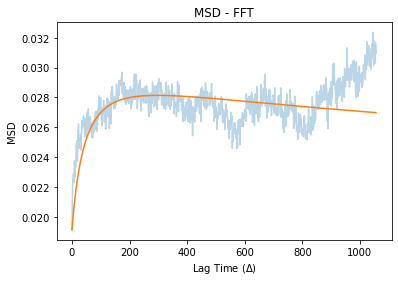

In [71]:
mu_opt, beta_opt = opt_params #use the optimal parameters

msd_theo_array = msd_theo(msd_lag, mu_opt, beta_opt)
msd_plot(fft_msd[:], title = 'MSD - FFT', a = 0.3)
plt.plot(msd_theo_array + fft_msd[0] - msd_theo_array[0])  #make the first values of each array equal
plt.show()